In [ ]:
import pandas as pd
import numpy as np
from scipy import stats

from sklearn.preprocessing import StandardScaler, PolynomialFeatures, LabelEncoder
from keras.layers import Input, Embedding, Dense, Flatten, Dropout, SpatialDropout1D, Activation, concatenate
from tensorflow.keras.optimizers import Adam, SGD
from keras.layers.advanced_activations import ReLU, PReLU, LeakyReLU, ELU
from keras.layers import BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Model
from tensorflow.keras.utils import plot_model

In [ ]:
train = pd.read_csv("train.tiny.csv")
print(train.shape)

(1999, 41)


In [ ]:
train.head()

,Id,Label,I1,I2,I3,I4,I5,I6,I7,I8,I9,I10,I11,I12,I13,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,C15,C16,C17,C18,C19,C20,C21,C22,C23,C24,C25,C26
0,10000000,0,1.0,1,5.0,0.0,1382.0,4.0,15.0,2.0,181.0,1.0,2.0,NaN,2.0,68fd1e64,80e26c9b,fb936136,7b4723c4,25c83c98,7e0ccccf,de7995b8,1f89b562,a73ee510,a8cd5504,b2cb9c98,37c9c164,2824a5f6,1adce6ef,8ba8b39a,891b62e7,e5ba7672,f54016b9,21ddcdc9,b1252a9d,07b5194c,NaN,3a171ecb,c5c50484,e8b83407,9727dd16
1,10000001,0,2.0,0,44.0,1.0,102.0,8.0,2.0,2.0,4.0,1.0,1.0,NaN,4.0,68fd1e64,f0cf0024,6f67f7e5,41274cd7,25c83c98,fe6b92e5,922afcc0,0b153874,a73ee510,2b53e5fb,4f1b46f3,623049e6,d7020589,b28479f6,e6c5b5cd,c92f3b61,07c540c4,b04e4670,21ddcdc9,5840adea,60f6221e,NaN,3a171ecb,43f13e8b,e8b83407,731c3655
2,10000002,0,2.0,0,1.0,14.0,767.0,89.0,4.0,2.0,245.0,1.0,3.0,3.0,45.0,287e684f,0a519c5c,02cf9876,c18be181,25c83c98,7e0ccccf,c78204a1,0b153874,a73ee510,3b08e48b,5f5e6091,8fe001f4,aa655a2f,07d13a8f,6dc710ed,36103458,8efede7f,3412118d,NaN,NaN,e587c466,ad3062eb,3a171ecb,3b183c5c,NaN,NaN
3,10000003,0,NaN,893,NaN,NaN,4392.0,NaN,0.0,0.0,0.0,NaN,0.0,NaN,NaN,68fd1e64,2c16a946,a9a87e68,2e17d6f6,25c83c98,fe6b92e5,2e8a689b,0b153874,a73ee510,efea433b,e51ddf94,a30567ca,3516f6e6,07d13a8f,18231224,52b8680f,1e88c74f,74ef3502,NaN,NaN,6b3a5ca6,NaN,3a171ecb,9117a34a,NaN,NaN
4,10000004,0,3.0,-1,NaN,0.0,2.0,0.0,3.0,0.0,0.0,1.0,1.0,NaN,0.0,8cf07265,ae46a29d,c81688bb,f922efad,25c83c98,13718bbd,ad9fa255,0b153874,a73ee510,5282c137,e5d8af57,66a76a26,f06c53ac,1adce6ef,8ff4b403,01adbab4,1e88c74f,26b3c7a7,NaN,NaN,21c9516a,NaN,32c7478e,b34f3128,NaN,NaN


In [ ]:
# Id 중복값은 없다
train.Id.duplicated().all()

False

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1999 entries, 0 to 1998
Data columns (total 41 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Id      1999 non-null   int64  
 1   Label   1999 non-null   int64  
 2   I1      1110 non-null   float64
 3   I2      1999 non-null   int64  
 4   I3      1550 non-null   float64
 5   I4      1579 non-null   float64
 6   I5      1906 non-null   float64
 7   I6      1506 non-null   float64
 8   I7      1906 non-null   float64
 9   I8      1997 non-null   float64
 10  I9      1906 non-null   float64
 11  I10     1110 non-null   float64
 12  I11     1906 non-null   float64
 13  I12     445 non-null    float64
 14  I13     1579 non-null   float64
 15  C1      1999 non-null   object 
 16  C2      1999 non-null   object 
 17  C3      1933 non-null   object 
 18  C4      1933 non-null   object 
 19  C5      1999 non-null   object 
 20  C6      1748 non-null   object 
 21  C7      1999 non-null   object 
 22  

In [ ]:
train['C20'].value_counts()

5840adea    351
a458ea53    350
b1252a9d    333
Name: C20, dtype: int64

In [ ]:
train[['I1', 'I2', 'I3', 'I4', 'I5', 'I6', 'I7', 'I8', 'I9', 'I10', 'I11' ,'I12', 'I13']] = train[['I1', 'I2', 'I3', 'I4', 'I5', 'I6', 'I7', 'I8', 'I9', 'I10', 'I11' ,'I12', 'I13']].fillna(0.0)

In [ ]:
train['C26'].value_counts()

49d68486    90
c84c4aec    40
b7d9c3bc    33
2fede552    24
9904c656    23
            ..
23318562     1
4e6f1778     1
8e1ae331     1
1cc46575     1
14886693     1
Name: C26, Length: 553, dtype: int64

In [ ]:
missing_dict = {'C1': '05db9164', 'C3': 'd032c263', 'C4' : 'd16679b9', 'C6': '7e0ccccf', 'C12': 'dfbb09fb','C16': '84898b2a','C19': '21ddcdc9','C20': '5840adea',
                'C21' : '0014c32a', 'C22' : 'ad3062eb', 'C24' : 'aee52b6f', 'C25' : 'e8b83407', 'C26' : '49d68486'}

for key, value in missing_dict.items():
    train[key] = train[key].fillna(value)

In [ ]:
#########Y값(label) 분리 
y = train['Label'].values
train.drop('Label', axis = 1, inplace=True)

In [ ]:
CATEGORICAL_COLUMNS = ['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11' ,'C12', 'C13',
                       'C14', 'C15', 'C16', 'C17', 'C18', 'C19', 'C20', 'C21', 'C22', 'C23', 'C24' ,'C25', 'C26']
CONTINUOUS_COLUMNS = ['I1', 'I2', 'I3', 'I4', 'I5', 'I6', 'I7', 'I8', 'I9', 'I10', 'I11' ,'I12', 'I13']
for c in CATEGORICAL_COLUMNS:
    le = LabelEncoder()
    train[c] = le.fit_transform(train[c])

In [ ]:
train.head()

,Id,I1,I2,I3,I4,I5,I6,I7,I8,I9,I10,I11,I12,I13,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,C15,C16,C17,C18,C19,C20,C21,C22,C23,C24,C25,C26
0,10000000,1.0,1,5.0,0.0,1382.0,4.0,15.0,2.0,181.0,1.0,2.0,0.0,2.0,33,126,1273,512,1,3,1021,5,1,579,648,250,124,3,445,642,8,510,22,2,39,2,1,584,26,320
1,10000001,2.0,0,44.0,1.0,102.0,8.0,2.0,2.0,4.0,1.0,1.0,0.0,4.0,33,238,580,272,1,5,672,2,1,142,282,441,675,13,748,924,0,364,22,0,478,2,1,193,26,243
2,10000002,2.0,0,1.0,14.0,767.0,89.0,4.0,2.0,245.0,1.0,3.0,3.0,45.0,9,13,20,818,1,3,917,2,1,194,336,679,535,2,365,244,6,114,22,0,1093,2,1,162,26,149
3,10000003,0.0,893,0.0,0.0,4392.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,33,42,878,194,1,5,233,2,1,849,822,780,160,2,85,382,1,240,22,0,534,2,1,436,26,149
4,10000004,3.0,-1,0.0,0.0,2.0,0.0,3.0,0.0,0.0,1.0,1.0,0.0,0.0,43,174,1025,1014,1,0,806,2,1,288,824,472,771,3,459,0,1,86,22,0,146,2,0,546,26,149


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train, y, test_size=0.3, random_state=42)

In [ ]:
X_train_category = np.array(X_train[CATEGORICAL_COLUMNS])
X_test_category = np.array(X_test[CATEGORICAL_COLUMNS])
X_train_countinue = np.array(X_train[CONTINUOUS_COLUMNS], dtype='float64')
X_test_countinue = np.array(X_test[CONTINUOUS_COLUMNS], dtype='float64')

In [ ]:
print( X_train_category[:1] )
print(X_test_category[:1])
print(X_train_countinue[:1])
print(X_test_countinue[:1])

[[   0   37 1124  134    1    2  504    2    1    7  316  165  355    2
    48  529    8  285   87    1  645    2    0  201   27  452]]
[[  56   77  137  141    1    3  159    2    1   37  879 1056  259    3
   806  278    3  388    6    1  829    4    0  423    0  401]]
[[0.000e+00 1.000e+00 4.000e+00 2.000e+00 1.965e+03 8.000e+00 2.700e+01
  8.000e+00 1.830e+02 0.000e+00 8.000e+00 0.000e+00 2.000e+00]]
[[  4.   0. 128.  42.   7.  44.   4.  44.  42.   1.   1.   2.  42.]]


In [ ]:
scaler = StandardScaler()
X_train_countinue = scaler.fit_transform(X_train_countinue)
X_test_countinue = scaler.transform(X_test_countinue)

In [ ]:
print(X_train_countinue[:1])
print(X_test_countinue[:1])

[[-0.27517646 -0.27234018 -0.16793015 -0.49090716 -0.22782553 -0.33840864
   0.25411584 -0.24999341  0.20486113 -0.58003612  1.66286592 -0.0940968
  -0.28749584]]
[[ 0.21476547 -0.27462392  0.86775853  3.86475557 -0.2675919  -0.22387285
  -0.17268682  1.18614985 -0.28336181  1.19561055 -0.31220333  0.57583409
   1.16661363]]


In [ ]:
####################################Polynomial 하게 바꿔줌 (비선형적인 설정으로 선형 회귀를 확장하는 방법. 즉 다항식 함수로 바꿔줌)

poly = PolynomialFeatures(degree=2, interaction_only=True)
X_train_category_poly = poly.fit_transform(X_train_category)
X_test_category_poly = poly.transform(X_test_category)

In [ ]:
print( X_train_category_poly[:1] )
print(X_test_category_poly[:1])

[[1.00000e+00 0.00000e+00 3.70000e+01 1.12400e+03 1.34000e+02 1.00000e+00
  2.00000e+00 5.04000e+02 2.00000e+00 1.00000e+00 7.00000e+00 3.16000e+02
  1.65000e+02 3.55000e+02 2.00000e+00 4.80000e+01 5.29000e+02 8.00000e+00
  2.85000e+02 8.70000e+01 1.00000e+00 6.45000e+02 2.00000e+00 0.00000e+00
  2.01000e+02 2.70000e+01 4.52000e+02 0.00000e+00 0.00000e+00 0.00000e+00
  0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00
  0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00
  0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00
  0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 4.15880e+04 4.95800e+03
  3.70000e+01 7.40000e+01 1.86480e+04 7.40000e+01 3.70000e+01 2.59000e+02
  1.16920e+04 6.10500e+03 1.31350e+04 7.40000e+01 1.77600e+03 1.95730e+04
  2.96000e+02 1.05450e+04 3.21900e+03 3.70000e+01 2.38650e+04 7.40000e+01
  0.00000e+00 7.43700e+03 9.99000e+02 1.67240e+04 1.50616e+05 1.12400e+03
  2.24800e+03 5.66496e+05 2.24800e+03 

In [ ]:
n = np.array([[1,2,3]])
poly2 = PolynomialFeatures(degree=2, interaction_only=True)
print(poly.fit_transform(n))

[[1. 1. 2. 3. 2. 3. 6.]]


In [ ]:
def get_deep_model():

    category_inputs = []
    category_embeds = []
    # 카테고리컬 데이터 임베딩
    for i in range(len(CATEGORICAL_COLUMNS)):
        input_i = Input(shape=(1,), dtype='int32')
        dim = len(np.unique(train[CATEGORICAL_COLUMNS[i]]))
        embed_dim = int(np.ceil(dim ** 0.5)) # embedding 차원을 0.5배 정도로 해서 한다.
        embed_i = Embedding(dim, embed_dim, input_length=1)(input_i)
        flatten_i = Flatten()(embed_i)
        category_inputs.append(input_i)
        category_embeds.append(flatten_i)
    # continuous 데이터 input
    continue_input = Input(shape=(len(CONTINUOUS_COLUMNS),))
    continue_dense = Dense(256, use_bias=False)(continue_input)
    # category와 continue를 합침
    concat_embeds = concatenate([continue_dense] + category_embeds)
    concat_embeds = Activation('relu')(concat_embeds)
    bn_concat = BatchNormalization()(concat_embeds)

    fc1 = Dense(512, use_bias=False)(bn_concat)
    relu1 = ReLU()(fc1)
    bn1 = BatchNormalization()(relu1)
    fc2 = Dense(256, use_bias=False)(bn1)
    relu2 = ReLU()(fc2)
    bn2 = BatchNormalization()(relu2)
    fc3 = Dense(128)(bn2)
    relu3 = ReLU()(fc3)
    
    return category_inputs, continue_input, relu3

In [ ]:
def get_wide_model():
    dim = X_train_category_poly.shape[1]
    return Input(shape=(dim,))

In [ ]:
category_inputs, continue_input, deep_model = get_deep_model()
wide_model = get_wide_model()

In [ ]:
####################WIDE 랑 DEEP이랑 합치기############################
out_layer = concatenate([deep_model, wide_model])
inputs = [continue_input] + category_inputs + [wide_model]
output = Dense(1, activation='sigmoid')(out_layer)
model = Model(inputs=inputs, outputs=output)

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 1)]          0           []                               
                                                                                              

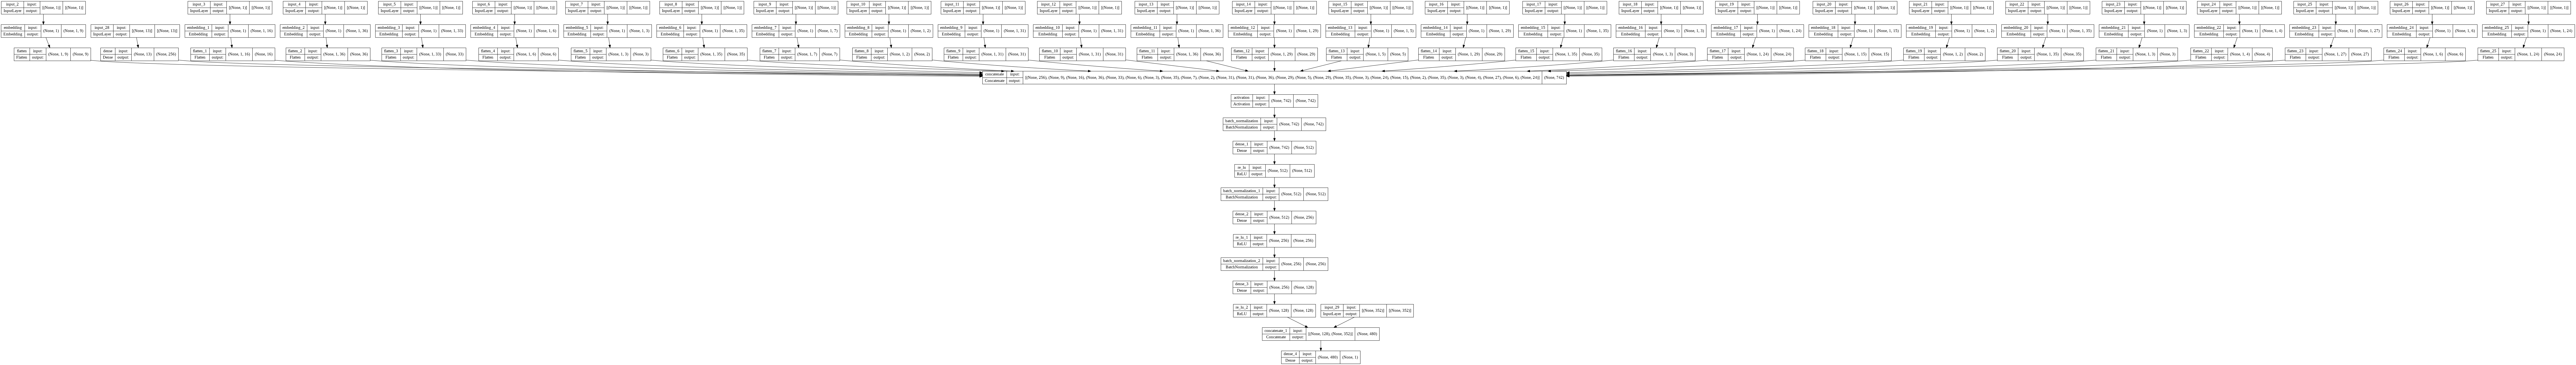

In [ ]:
!pip install pydot
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
checkpoint = ModelCheckpoint(filepath='./data/wide-deep.h5', monitor='val_loss', verbose=1, save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

In [ ]:
################입력데이터###########################

input_data = [X_train_countinue] + [X_train_category[:, i] for i in range(X_train_category.shape[1])] + [X_train_category_poly]


epochs = 30
optimizer ='adam'
batch_size = 128


model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
model.fit(input_data, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.15, callbacks=[checkpoint, early_stopping])


Epoch 1/30
10/10 [==============================] - ETA: 0s - loss: 3747.7090 - accuracy: 0.7258
Epoch 1: val_loss did not improve from 6182.64502
10/10 [==============================] - 7s 84ms/step - loss: 3747.7090 - accuracy: 0.7258 - val_loss: 6861.8940 - val_accuracy: 0.6238
Epoch 2/30
 9/10 [==========================>...] - ETA: 0s - loss: 3053.9353 - accuracy: 0.7517
Epoch 2: val_loss did not improve from 6182.64502
10/10 [==============================] - 0s 30ms/step - loss: 3068.2959 - accuracy: 0.7502 - val_loss: 6291.7764 - val_accuracy: 0.6857
Epoch 3/30
10/10 [==============================] - ETA: 0s - loss: 2686.0298 - accuracy: 0.7511
Epoch 3: val_loss improved from 6182.64502 to 5972.19629, saving model to ./data/wide-deep.h5
10/10 [==============================] - 0s 44ms/step - loss: 2686.0298 - accuracy: 0.7511 - val_loss: 5972.1963 - val_accuracy: 0.7286
Epoch 4/30
10/10 [==============================] - ETA: 0s - loss: 2840.0391 - accuracy: 0.7485
Epoch 4: v

In [ ]:
eval_input_data = [X_test_countinue] + [X_test_category[:, i] for i in range(X_test_category.shape[1])] + [X_test_category_poly]

In [ ]:
loss, acc = model.evaluate(eval_input_data, y_test)

19/19 [==============================] - 0s 4ms/step - loss: 4827.3340 - accuracy: 0.7300


In [ ]:
print(f'test_loss:{loss} - test_acc:{acc}')

test_loss:4827.333984375 - test_acc:0.7300000190734863


In [ ]:
y_test.sum()

123